In [1]:
!git clone https://github.com/Hevensh/DataSetMaker.git
!git clone https://github.com/Hevensh/SFM_trial.git

Cloning into 'DataSetMaker'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 237 (delta 55), reused 0 (delta 0), pack-reused 147
Receiving objects: 100% (237/237), 76.71 KiB | 6.97 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Cloning into 'SFM_trial'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 17.17 KiB | 1.56 MiB/s, done.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.utils import plot_model

from SFM_trial.SFM import SFM
from DataSetMaker.DataLoader import DataLoader

In [3]:
%cd /kaggle/input/yahoo-finance-all-stocks-dataset-daily-update

import glob
file = glob.glob('*')
file_list = np.sort(file)

/kaggle/input/yahoo-finance-all-stocks-dataset-daily-update


In [4]:
def formDatapairs(
        self,
):
    inputs_train = tf.cast(self.train_Yt[:, :, 1:] - self.train_Yt[:, :, :-1], tf.float32)
    targets_train = tf.cast((self.train_Yt_target[:, :, -1:]-self.train_Yt[:, :, -1:]), tf.float32)

    inputs_val = tf.cast(self.val_Yt[:, :, 1:] - self.val_Yt[:, :, :-1], tf.float32)
    targets_val = tf.cast((self.val_Yt_target[:, :, -1:]-self.val_Yt[:, :, :1]), tf.float32)

    u, c = np.unique(targets_train, return_counts=True)
    self.train_per = np.round(c / c.sum() * 100, 2)
    
    plt.subplot(211)
    plt.hist(targets_train.numpy().flatten(), bins=32, alpha=0.2)
    plt.grid('on')
    plt.show()

    plt.subplot(212)
    plt.hist(targets_val.numpy().flatten(), bins=32, alpha=0.2)
    plt.grid('on')
    plt.show()

    return inputs_train, targets_train, inputs_val, targets_val

DataLoader.formDatapairs = formDatapairs

In [5]:
window_len = 1
pred_days = 1

last_day = '2018-1-1'

min_num_segment = 1
length_segment = 32

use_real_gap = False # if use real date gap when detrend
use_weights = True # if use weights when detrend
temperature = 77 # higher the tempe, lower the effect of weights
degree = 2 # the degree of polyfit when detrend

input_data_type=(True, False, False, False, False)
# choose the type of input data (Yt, Et, Beta, Date, Stock) 
target_data_type=(True, False, False)
# choose the type of target data (Yt, Et, Beta) 

In [6]:
testDataLoader = DataLoader(file_list)

In [7]:
testDataLoader.loadTheData(
    21,
    last_day = last_day,
)

loading is done [====================] - 21/21  1s 84ms/file


In [8]:
testDataLoader.chooseFeasibleData(
    window_len + 1,
    pred_days,
    
    min_num_segment,
    length_segment,
)

4722 segments from 20 feasible stocks,
each segment has 32 samples pairs.
validation for each stock has 747 samples pairs.


In [9]:
testDataLoader.processTheData(
    use_real_gap,
    use_weights,
    temperature,
    degree,
    input_data_type,
    target_data_type,
)

slicing is done [====================] - 20/20  0s 3ms/stock
segmenting is done [====================] - 4722/4722  1039s 220ms/segment


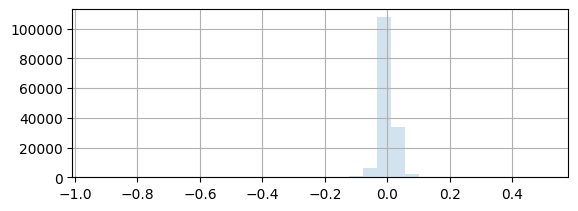

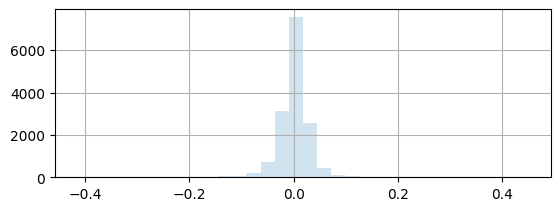

In [10]:
inputs_train,targets_train,inputs_val,targets_val = testDataLoader.formDatapairs()

In [11]:
def show_history(history):
    plt.plot(
        history.epoch, history.history.get('loss'),
        history.epoch, history.history.get('val_loss'),
    )
    plt.legend([
        'loss', 
        'val_loss', 
    ])
    plt.grid('on')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.show()

In [12]:
inputDYt = Input(shape=(None, 1),name='DY_t')
outputDYt = layers.Conv1D(1, 3, padding='causal')(inputDYt)

AR_model = Model(inputDYt,outputDYt,
               name='model_for_dy')
AR_model.summary()

Model: "model_for_dy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DY_t (InputLayer)           [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 1)           4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [13]:
AR_model.compile(
    optimizer='Adam', 
    loss='mse',
)
history_AR = AR_model.fit(
    inputs_train,
    targets_train,
    batch_size=64,
    epochs=96,
    validation_data=(inputs_val,targets_val),
    verbose=0,
)

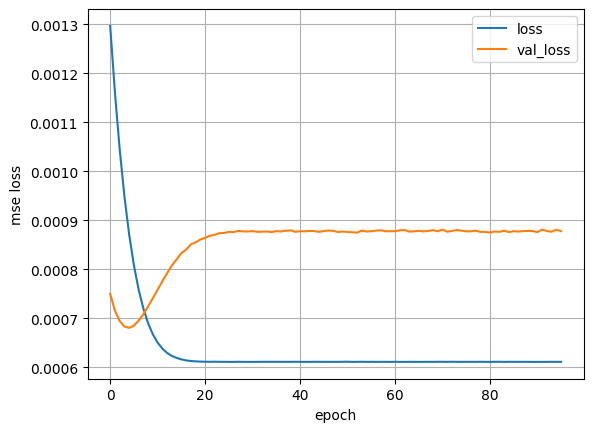

In [14]:
show_history(history_AR)

In [15]:
pred_AR_train = AR_model.predict(inputs_train)
pred_AR_val = AR_model.predict(inputs_val)

1/1 [==============================] - 0s 58ms/step


In [16]:
inputDYt = Input(shape=(None,1),name='DY_t')
outputDYt = layers.Dense(1)(layers.LSTM(4, return_sequences=True)(inputDYt))

lstm_model = Model(inputDYt,outputDYt,
               name='lstm_dy')
lstm_model.summary()

Model: "lstm_dy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DY_t (InputLayer)           [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 4)           96        
                                                                 
 dense (Dense)               (None, None, 1)           5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_model.compile(
    optimizer='Adam', 
    loss='mse',
)
history_lstm = lstm_model.fit(
    inputs_train,
    targets_train,
    batch_size=16,
    epochs=32,
    validation_data=(inputs_val,targets_val),
    verbose=1,
)

Epoch 1/32
296/296 [==============================] - 6s 14ms/step - loss: 6.1290e-04 - val_loss: 8.8471e-04
Epoch 2/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1177e-04 - val_loss: 8.8592e-04
Epoch 3/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1127e-04 - val_loss: 8.9005e-04
Epoch 4/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1122e-04 - val_loss: 8.7981e-04
Epoch 5/32
296/296 [==============================] - 4s 12ms/step - loss: 6.1129e-04 - val_loss: 8.8444e-04
Epoch 6/32
296/296 [==============================] - 4s 12ms/step - loss: 6.1151e-04 - val_loss: 8.8156e-04
Epoch 7/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1103e-04 - val_loss: 8.7960e-04
Epoch 8/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1093e-04 - val_loss: 8.7984e-04
Epoch 9/32
296/296 [==============================] - 4s 13ms/step - loss: 6.1096e-04 - val_loss: 8.7959e-04
Epoch 10/32
296/296

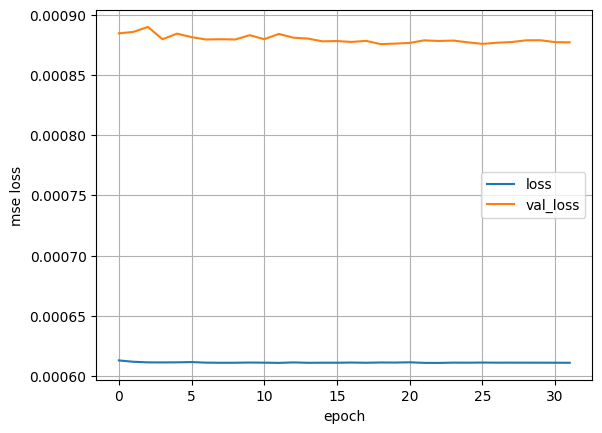

In [18]:
show_history(history_lstm)

In [19]:
pred_lstm_train = lstm_model.predict(inputs_train)
pred_lstm_val = lstm_model.predict(inputs_val)

1/1 [==============================] - 0s 447ms/step


In [20]:
inputDYt = Input(shape=(None,1),name='DY_t')
outputDYt = layers.Dense(1, use_bias=False)(SFM(2,4)(inputDYt))

sfm_model = Model(inputDYt,outputDYt,
               name='sfm_dy')
_ = sfm_model(inputs_train[:4])
sfm_model.summary()

Model: "sfm_dy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DY_t (InputLayer)           [(None, None, 1)]         0         
                                                                 
 sfm (SFM)                   (None, None, 2)           58        
                                                                 
 dense_1 (Dense)             (None, None, 1)           2         
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


In [21]:
sfm_model.compile(
    optimizer='Adam', 
    loss='mse',
)
history_sfm = sfm_model.fit(
    inputs_train,
    targets_train,
    batch_size=2,
    epochs=8,
    validation_data=(inputs_val,targets_val),
    verbose=1,
)

Epoch 1/8
2361/2361 [==============================] - 91s 34ms/step - loss: 0.0035 - val_loss: 9.1598e-04
Epoch 2/8
2361/2361 [==============================] - 23s 10ms/step - loss: 6.1476e-04 - val_loss: 9.0015e-04
Epoch 3/8
2361/2361 [==============================] - 22s 9ms/step - loss: 6.1212e-04 - val_loss: 8.8833e-04
Epoch 4/8
2361/2361 [==============================] - 22s 10ms/step - loss: 6.1167e-04 - val_loss: 8.8599e-04
Epoch 5/8
2361/2361 [==============================] - 22s 9ms/step - loss: 6.1184e-04 - val_loss: 8.8611e-04
Epoch 6/8
2361/2361 [==============================] - 23s 10ms/step - loss: 6.1173e-04 - val_loss: 8.8172e-04
Epoch 7/8
2361/2361 [==============================] - 23s 10ms/step - loss: 6.1159e-04 - val_loss: 8.8247e-04
Epoch 8/8
2361/2361 [==============================] - 23s 10ms/step - loss: 6.1158e-04 - val_loss: 8.8467e-04


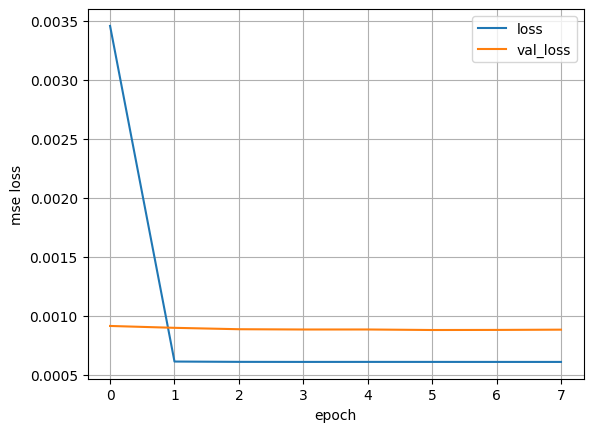

In [22]:
show_history(history_sfm)

In [23]:
pred_sfm_train = sfm_model.predict(inputs_train)
pred_sfm_val = sfm_model.predict(inputs_val)

1/1 [==============================] - 0s 74ms/step


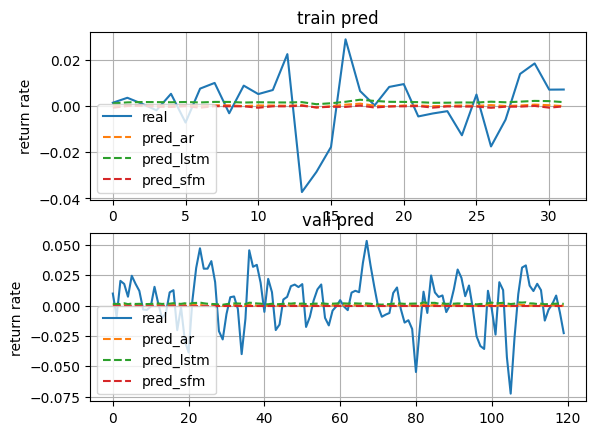

In [24]:
k = 0
n = 120

plt.subplot(211)
plt.plot(targets_train[0, -n:])
plt.plot(pred_AR_train[0, -n:], '--')
plt.plot(pred_lstm_train[0, -n:], '--')
plt.plot(pred_sfm_train[0, -n:], '--')
plt.legend(['real', 'pred_ar', 'pred_lstm', 'pred_sfm'])
plt.ylabel('return rate')
plt.title('train pred')
plt.grid('on')

plt.subplot(212)
plt.plot(targets_val[0, :n])
plt.plot(pred_AR_val[0, :n], '--')
plt.plot(pred_lstm_val[0, :n], '--')
plt.plot(pred_sfm_val[0, :n], '--')
plt.legend(['real', 'pred_ar', 'pred_lstm', 'pred_sfm'])
plt.ylabel('return rate')
plt.title('vali pred')
plt.grid('on')

plt.show()

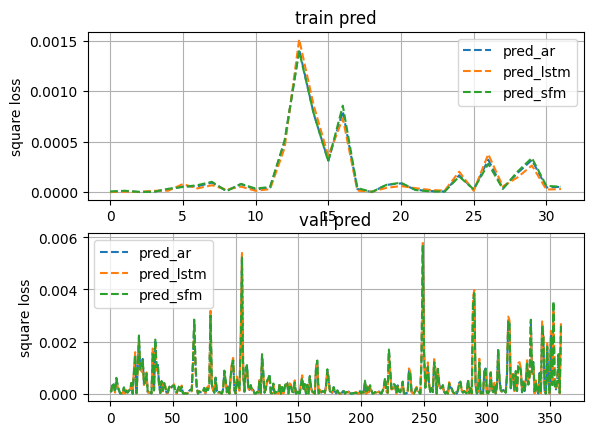

In [25]:
k = 0
n = 360

plt.subplot(211)
plt.plot((targets_train[0, -n:] - pred_AR_train[0, -n:]) ** 2, '--')
plt.plot((targets_train[0, -n:] - pred_lstm_train[0, -n:]) ** 2, '--')
plt.plot((targets_train[0, -n:] - pred_sfm_train[0, -n:]) ** 2, '--')
plt.legend(['pred_ar', 'pred_lstm', 'pred_sfm'])
plt.ylabel('square loss')
plt.title('train pred')
plt.grid('on')

plt.subplot(212)
plt.plot((targets_val[0, :n] - pred_AR_val[0, :n]) ** 2, '--')
plt.plot((targets_val[0, :n] - pred_lstm_val[0, :n]) ** 2, '--')
plt.plot((targets_val[0, :n] - pred_sfm_val[0, :n]) ** 2, '--')
plt.legend(['pred_ar', 'pred_lstm', 'pred_sfm'])
plt.ylabel('square loss')
plt.title('vali pred')
plt.grid('on')

plt.show()